In [1]:
import os
import datetime

from time import perf_counter

from filtration import Filtration
from boundary import Boundary
from reducer import reduce_greedy, reduce_smart
from barcode import write_barcode, plot_barcode_reduction, build_intervals, betti_from_intervals, guess_space

def get_barcode(filtration_path: str, barcode_folder_path: str, method: str = "both") -> tuple[Boundary, object]:
    """
    Compute the persistent homology barcode from a filtration file.
    Args:
        filtration_path (str): Path to the filtration file.
        barcode_folder_path (str): Path to the output barcode file.
        method (str): Reduction method to use ("greedy", "smart", or "both").
    """

    assert method in ("greedy", "smart", "both"), "method must be one of 'greedy', 'smart', or 'both'."

    tps_filtration = datetime.datetime.now()
    filtration = Filtration.from_file(filtration_path)
    tps_filtration = (datetime.datetime.now() - tps_filtration).total_seconds()

    tps_boundary = datetime.datetime.now()
    boundary_base = Boundary.from_filtration(filtration, strict=True)
    tps_boundary = (datetime.datetime.now() - tps_boundary).total_seconds()

    input_filename = '.'.join(os.path.basename(filtration_path).split(".")[:-1])
    print(f"=== Computing barcode for filtration '{input_filename}' ===")

    if method in ("greedy", "both"):
        # Greedy
        boundary_greedy = boundary_base.copy()
        t0 = perf_counter()
        result_greedy, stats_greedy = reduce_greedy(boundary_greedy)
        t1 = perf_counter()
        write_barcode(
            boundary_greedy.simplices,
            result_greedy.lowest_row_of_col,
            result_greedy.birth_to_death,
            os.path.join(barcode_folder_path, f"{input_filename}_barcode_greedy.txt"),
        )
        tps_reduction = t1 - t0
        print(f"[greedy] time = {(t1 - t0)*1000:.3f} ms, "
            f"adds = {stats_greedy.column_additions}, pivots = {stats_greedy.pivots_finalized}")
        
        boundary, result = boundary_greedy, result_greedy

    if method in ("smart", "both"):
        # Smart
        boundary_smart = boundary_base.copy()
        t2 = perf_counter()
        result_smart, stats_smart = reduce_smart(boundary_smart)
        t3 = perf_counter()
        write_barcode(
            boundary_smart.simplices,
            result_smart.lowest_row_of_col,
            result_smart.birth_to_death,
            os.path.join(barcode_folder_path, f"{input_filename}_barcode_smart.txt"),
        )
        tps_reduction = t3 - t2
        print(f"[smart ] time = {(t3 - t2)*1000:.3f} ms, "
            f"adds = {stats_smart.column_additions}, pivots = {stats_smart.pivots_finalized}")
        
        boundary, result = boundary_smart, result_smart

    
    print(f"Filtration time: {tps_filtration} s")
    print(f"Boundary matrix construction time: {tps_boundary} s")
    print(f"Reduction time: {tps_reduction} s")
    print(f"Total time: {tps_filtration + tps_boundary + tps_reduction} s")

    return input_filename, boundary, result


In [2]:
filename, boundary, result = get_barcode(
    # filtration_path="../data/filtration/n-spheres/7-sphere.txt",
    filtration_path="../data/filtration/filtration_A.txt",
    barcode_folder_path="../data/barcodes/filtrations",
    method="smart"
)

=== Computing barcode for filtration 'filtration_A' ===
[smart ] time = 8270.358 ms, adds = 1049823, pivots = 214321
Filtration time: 1.006802 s
Boundary matrix construction time: 1.211381 s
Reduction time: 8.270358459092677 s
Total time: 10.488541459092676 s


Betti: {0: 1}
Guess: contractible


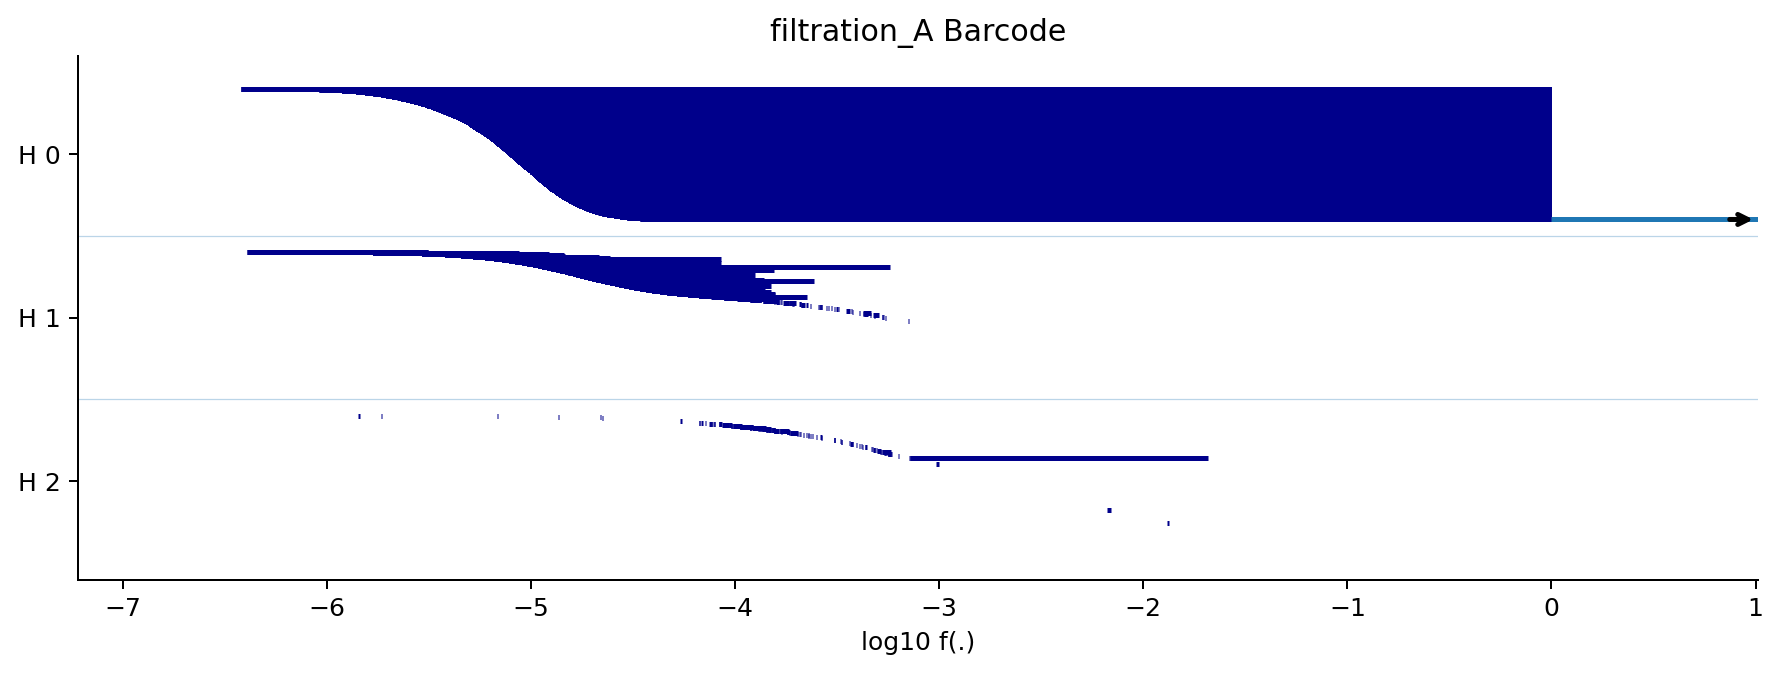

In [3]:
# 1) Betti & topology guess (on raw intervals)
intervals = build_intervals(boundary.simplices, result.lowest_row_of_col, result.birth_to_death)
betti = betti_from_intervals(intervals)
print("Betti:", betti)
print("Guess:", guess_space(betti))

plot_barcode_reduction(
    boundary.simplices, 
    result.lowest_row_of_col, 
    result.birth_to_death,
    outfile=f"../data/barcodes/filtrations/{filename}_barcode.png", 
    title=f"{filename} Barcode", 
    x_mode="log_values", 
    # min_length=0.05
)

=== Computing barcode for filtration '0-sphere' ===
[smart ] time = 0.027 ms, adds = 0, pivots = 0
Filtration time: 0.000607 s
Boundary matrix construction time: 1.5e-05 s
Reduction time: 2.674991264939308e-05 s
Total time: 0.0006487499126493931 s
Computation for 0-sphere took 0.267042
Betti: {0: 2}
Guess: 2 disjoint contractible components


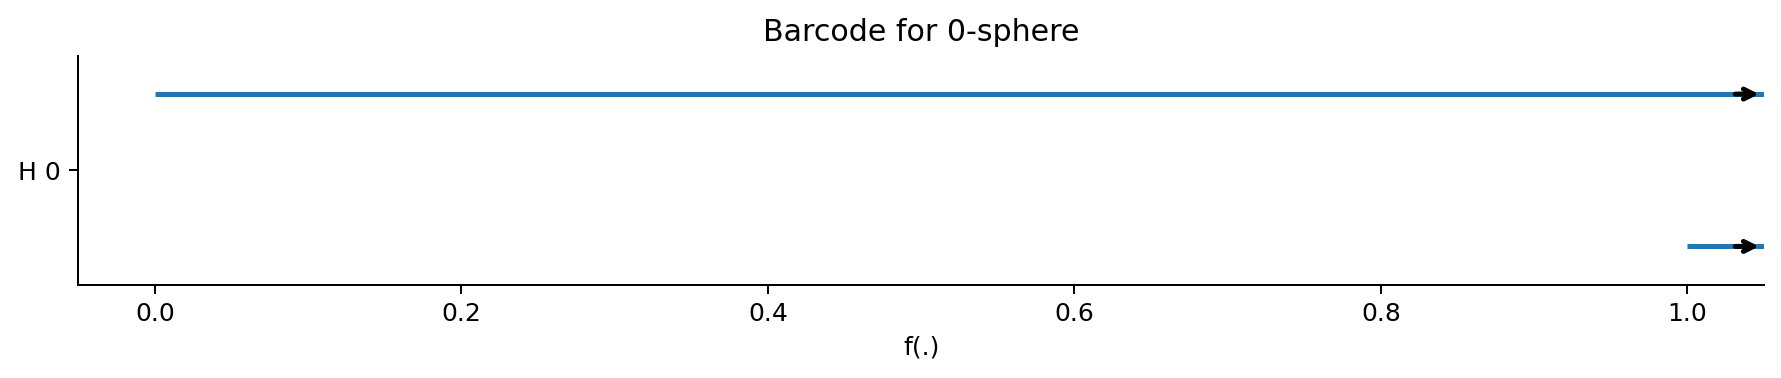

=== Computing barcode for filtration '1-sphere' ===
[smart ] time = 0.016 ms, adds = 2, pivots = 2
Filtration time: 0.001298 s
Boundary matrix construction time: 3.7e-05 s
Reduction time: 1.550000160932541e-05 s
Total time: 0.0013505000016093252 s
Computation for 1-sphere took 0.001898
Betti: {0: 1, 1: 1}
Guess: circle-like (S1)


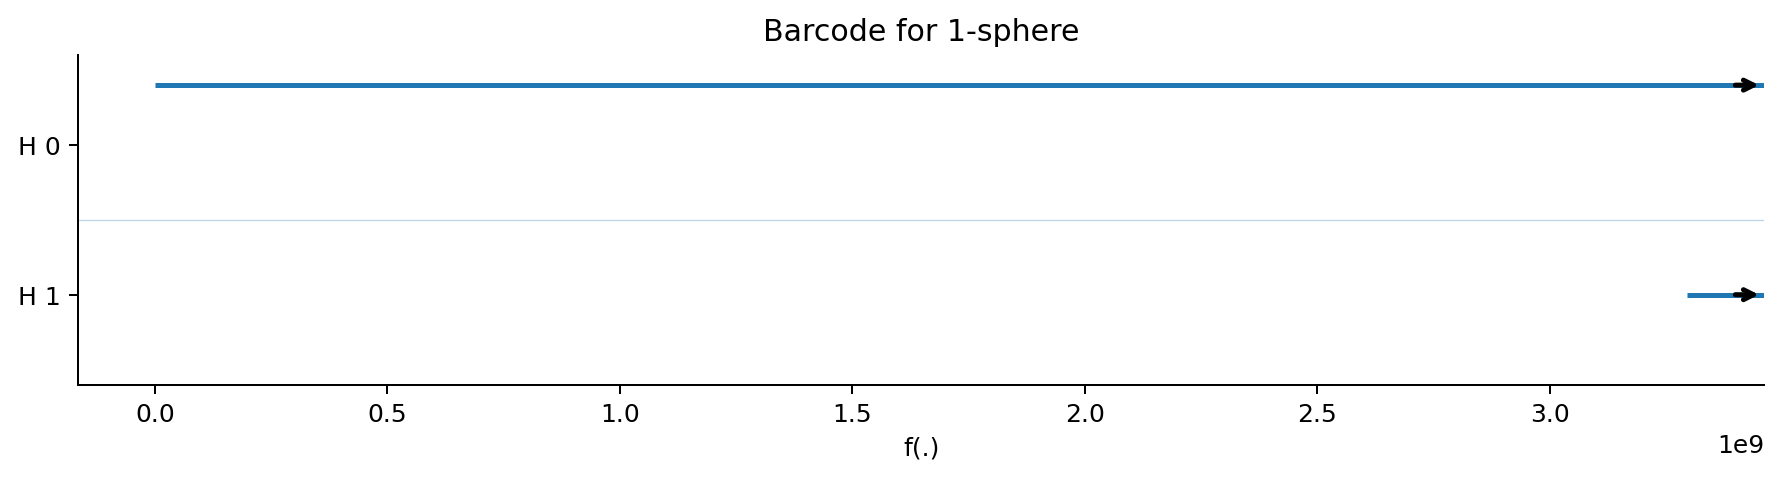

=== Computing barcode for filtration '2-sphere' ===
[smart ] time = 0.028 ms, adds = 9, pivots = 6
Filtration time: 0.000964 s
Boundary matrix construction time: 2.7e-05 s
Reduction time: 2.8458889573812485e-05 s
Total time: 0.0010194588895738124 s
Computation for 2-sphere took 0.001505
Betti: {0: 1, 2: 1}
Guess: sphere-like (S2)


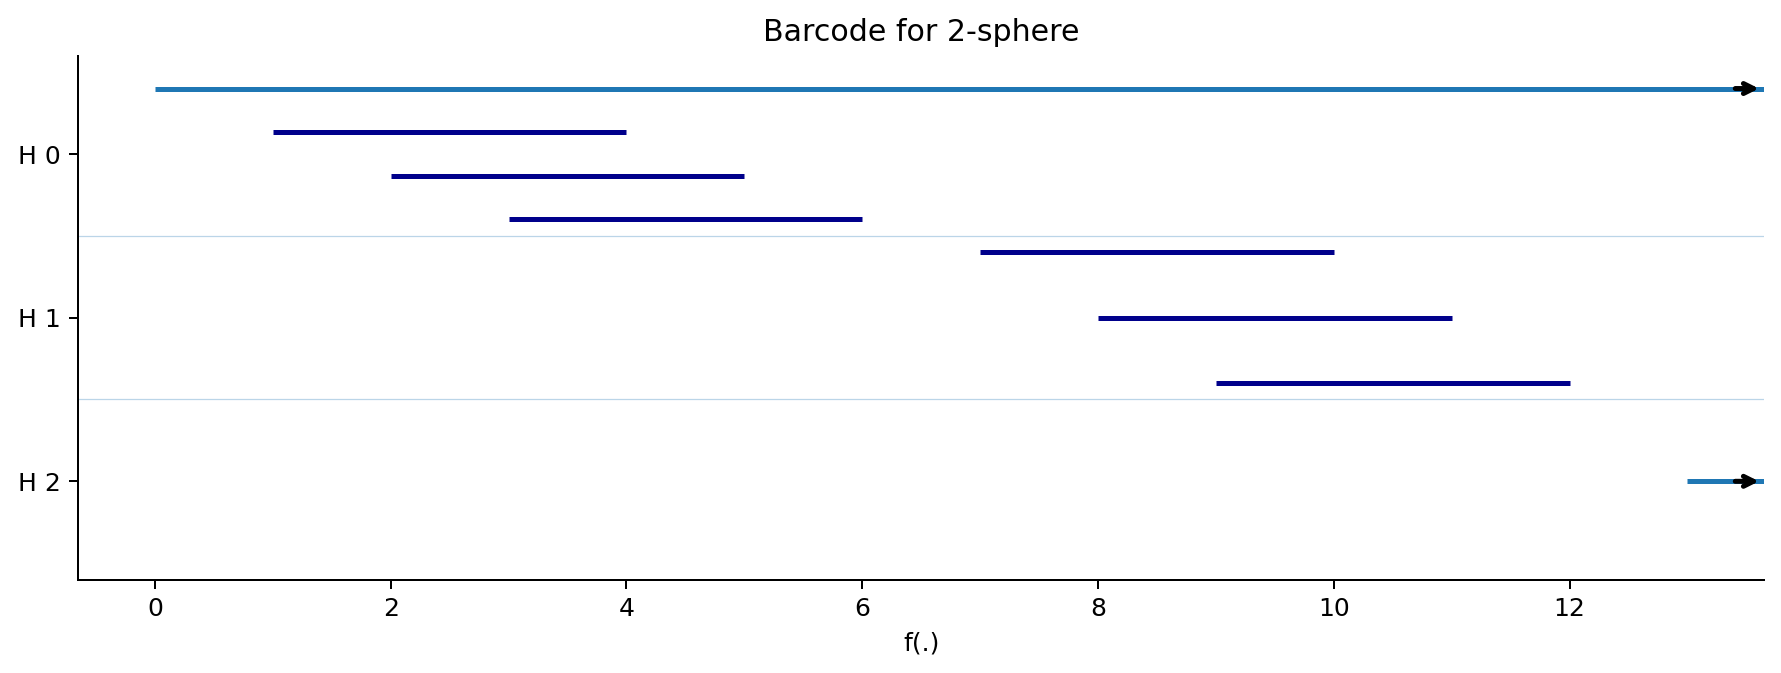

=== Computing barcode for filtration '3-sphere' ===
[smart ] time = 0.062 ms, adds = 28, pivots = 14
Filtration time: 0.00043 s
Boundary matrix construction time: 5.3e-05 s
Reduction time: 6.174994632601738e-05 s
Total time: 0.0005447499463260173 s
Computation for 3-sphere took 0.001323
Betti: {0: 1, 3: 1}
Guess: contractible


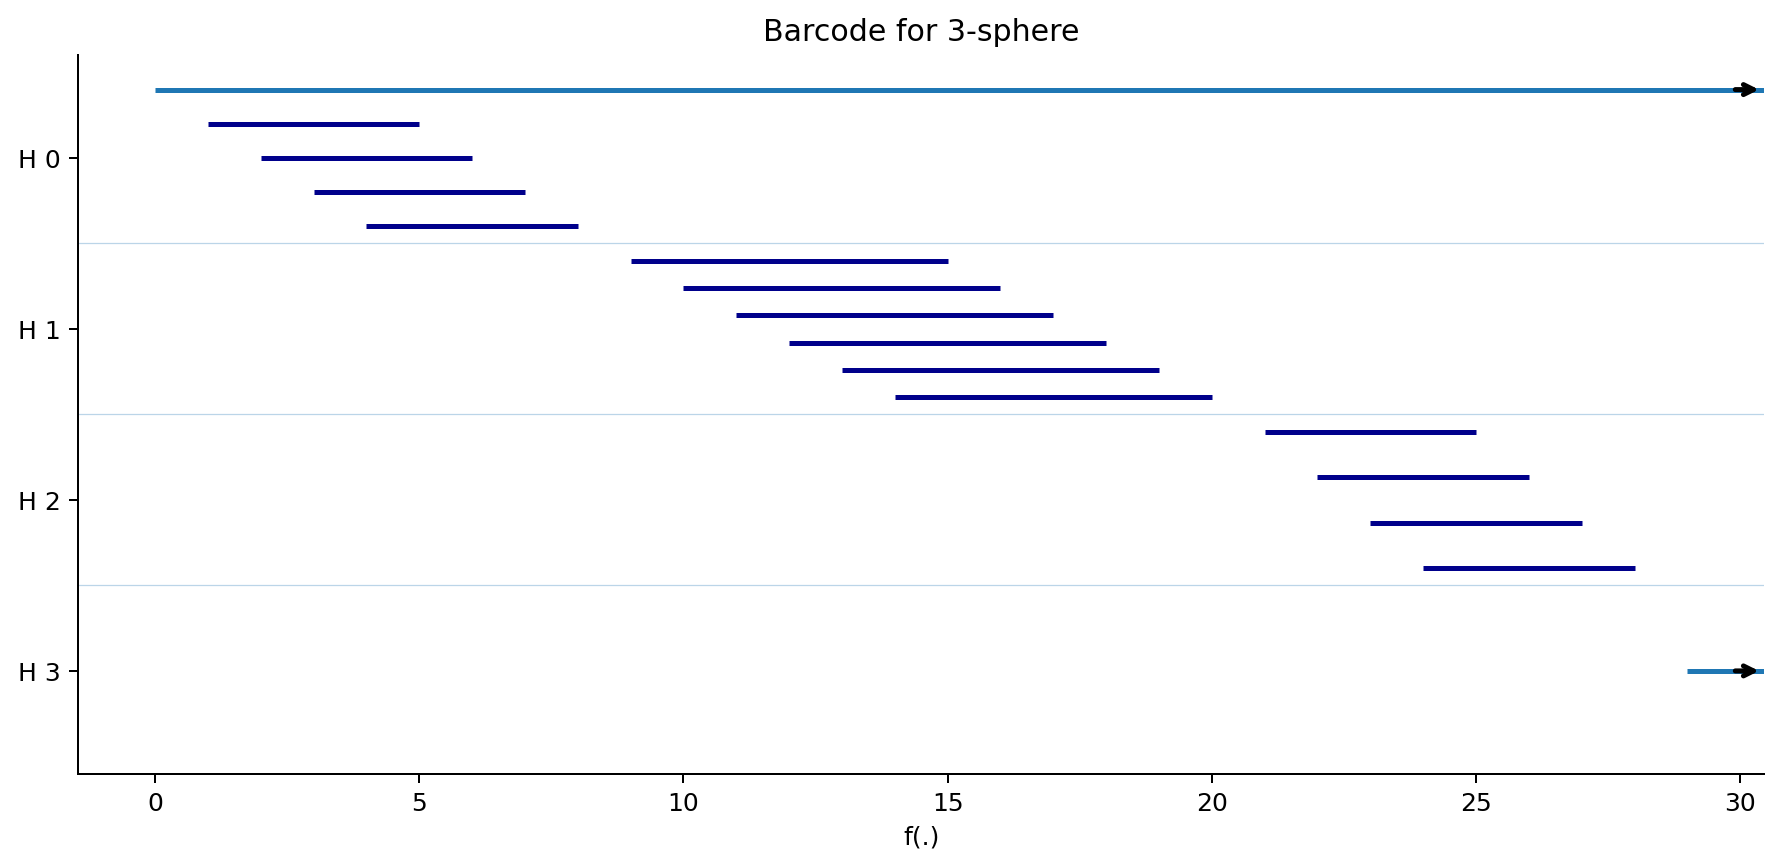

=== Computing barcode for filtration '4-sphere' ===
[smart ] time = 0.155 ms, adds = 75, pivots = 30
Filtration time: 0.000533 s
Boundary matrix construction time: 0.000135 s
Reduction time: 0.00015520770102739334 s
Total time: 0.0008232077010273934 s
Computation for 4-sphere took 0.001127
Betti: {0: 1, 4: 1}
Guess: contractible


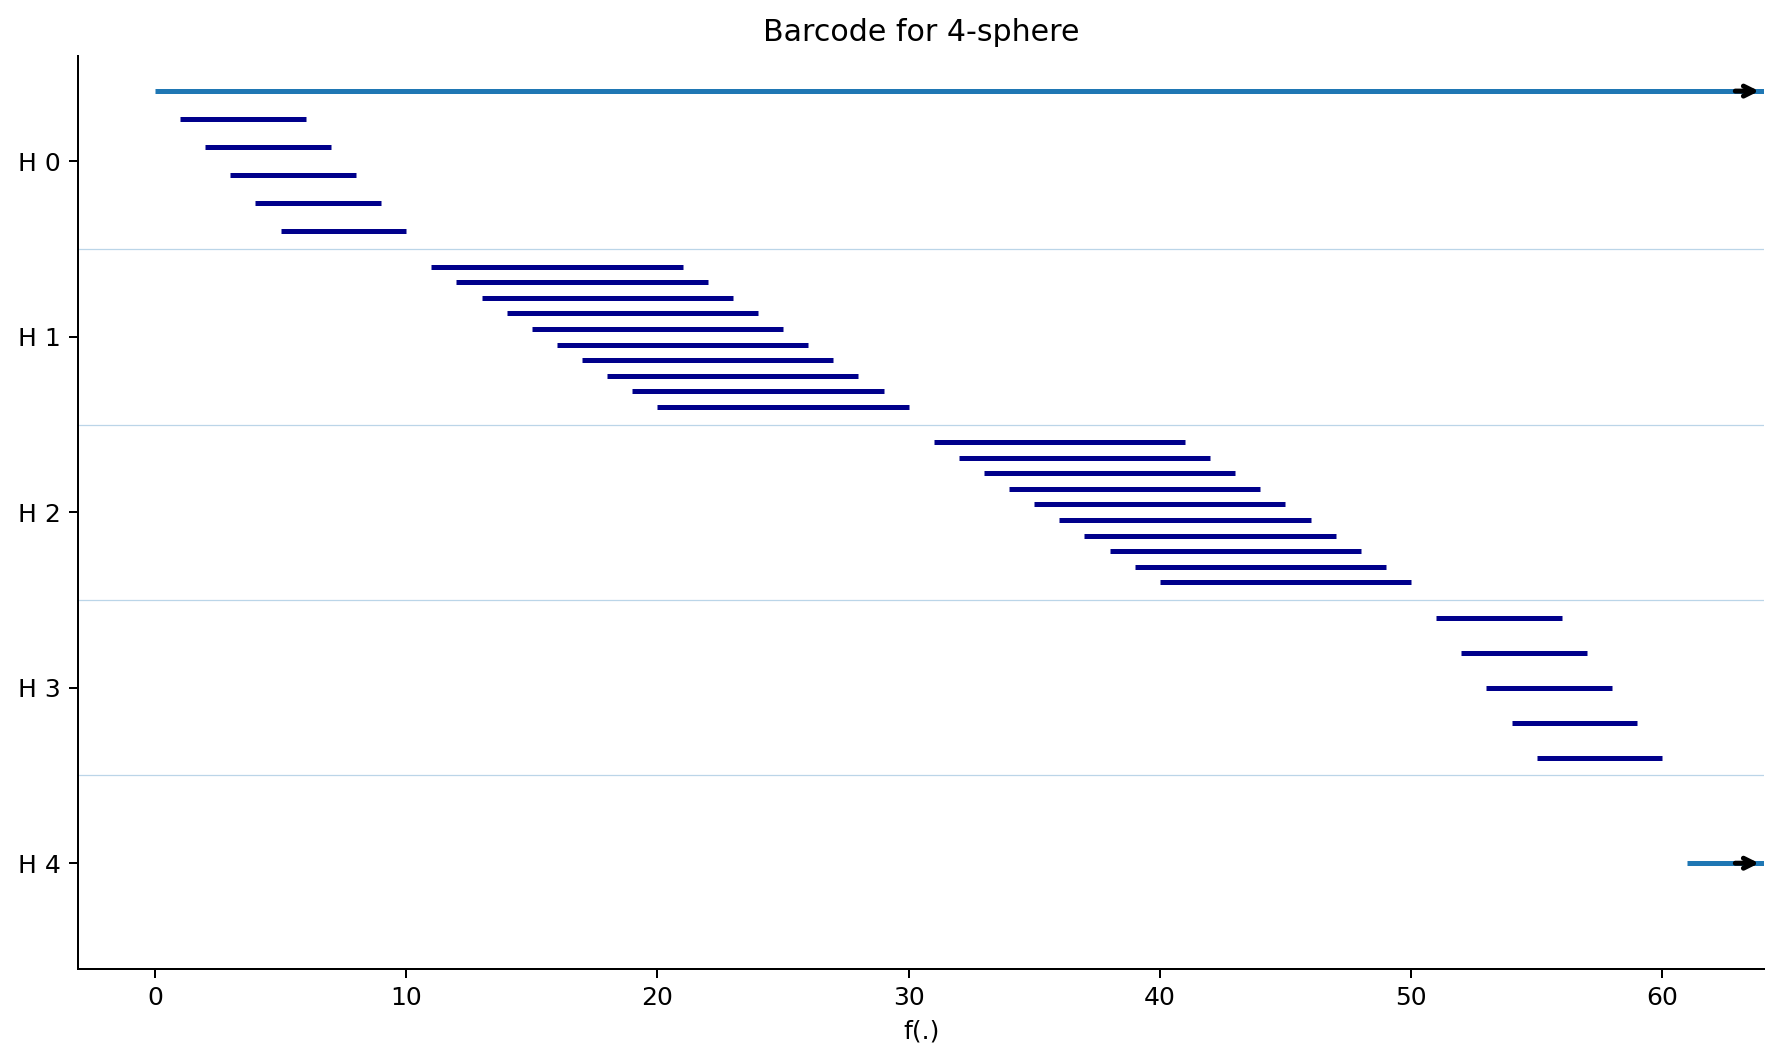

=== Computing barcode for filtration '5-sphere' ===
[smart ] time = 0.399 ms, adds = 186, pivots = 62
Filtration time: 0.000816 s
Boundary matrix construction time: 0.000514 s
Reduction time: 0.00039895810186862946 s
Total time: 0.0017289581018686295 s
Computation for 5-sphere took 0.002278
Betti: {0: 1, 5: 1}
Guess: contractible


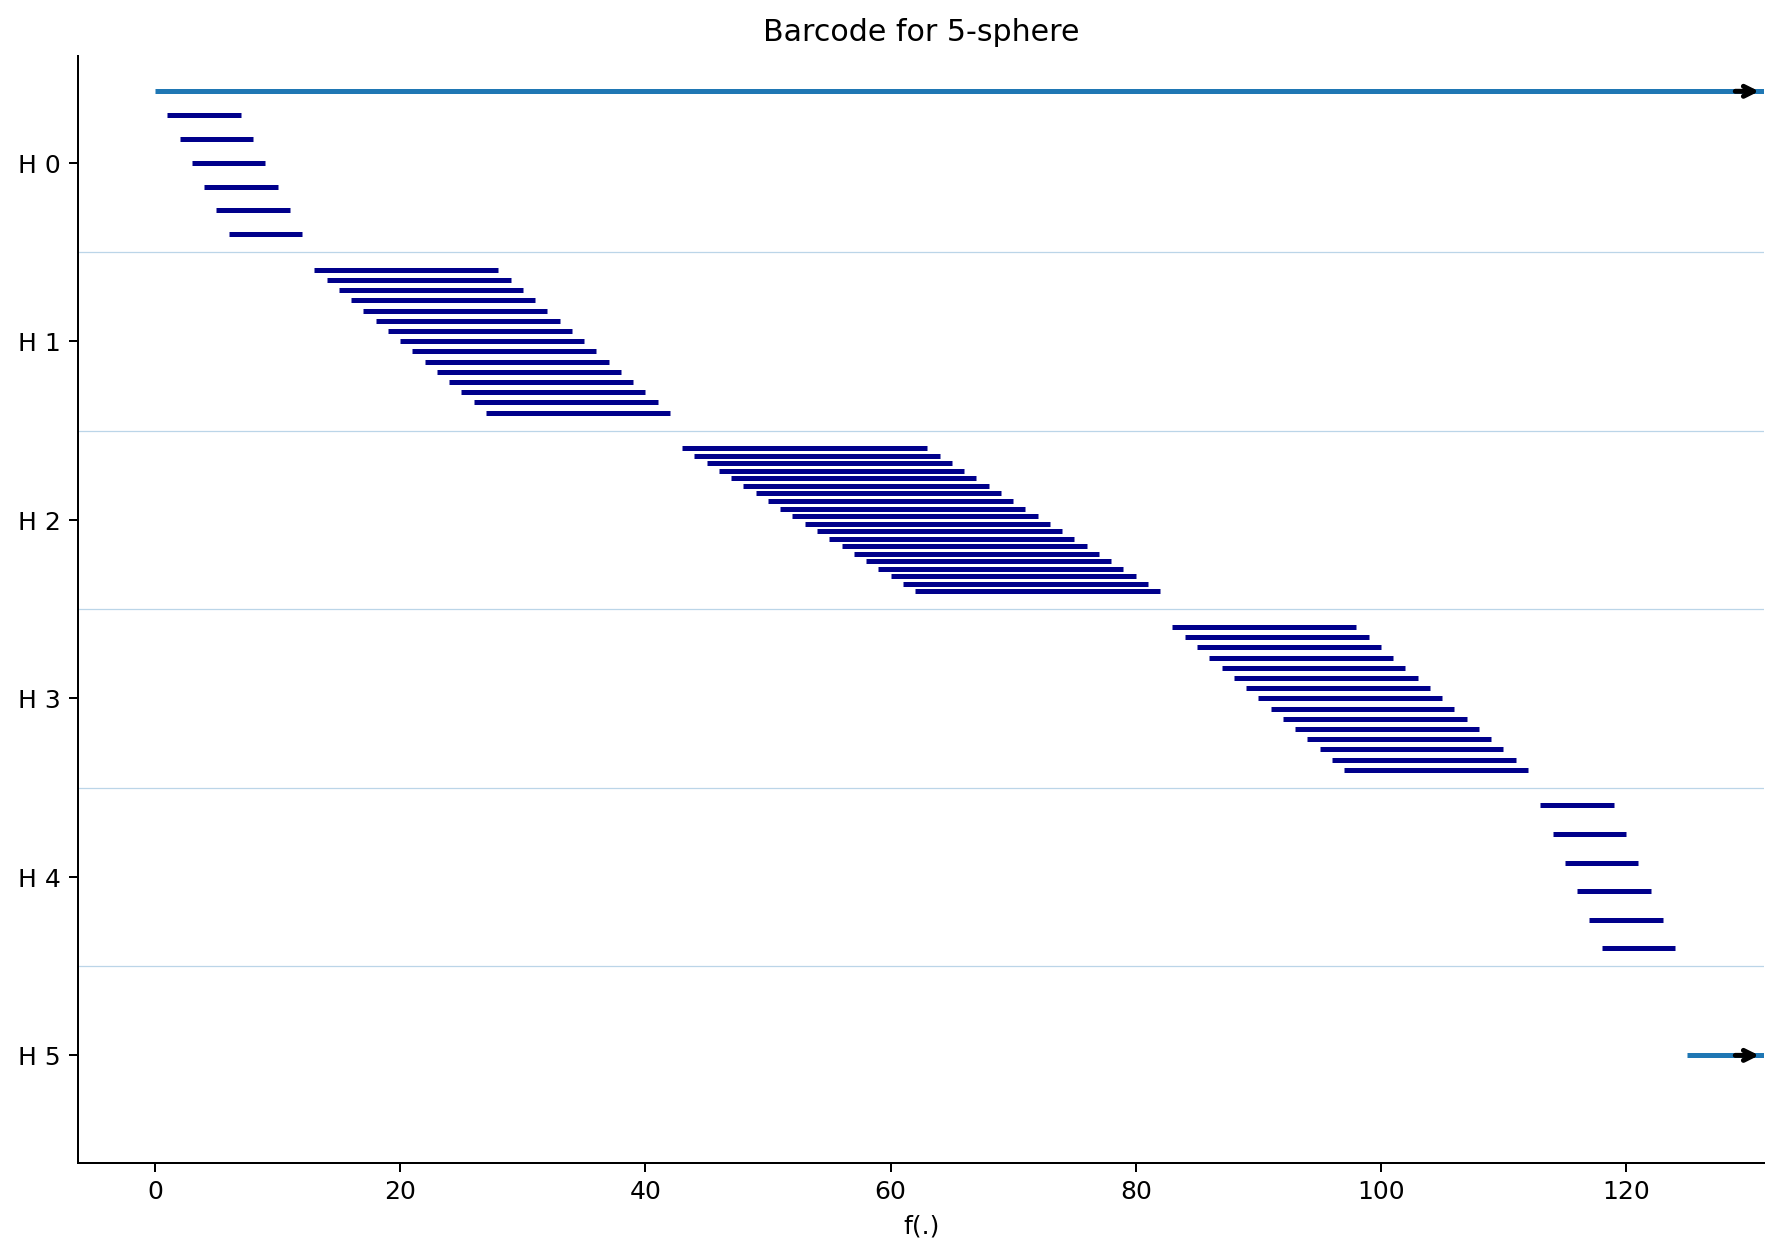

=== Computing barcode for filtration '6-sphere' ===
[smart ] time = 0.930 ms, adds = 441, pivots = 126
Filtration time: 0.000759 s
Boundary matrix construction time: 0.002036 s
Reduction time: 0.0009295833297073841 s
Total time: 0.0037245833297073843 s
Computation for 6-sphere took 0.004243
Betti: {0: 1, 6: 1}
Guess: contractible


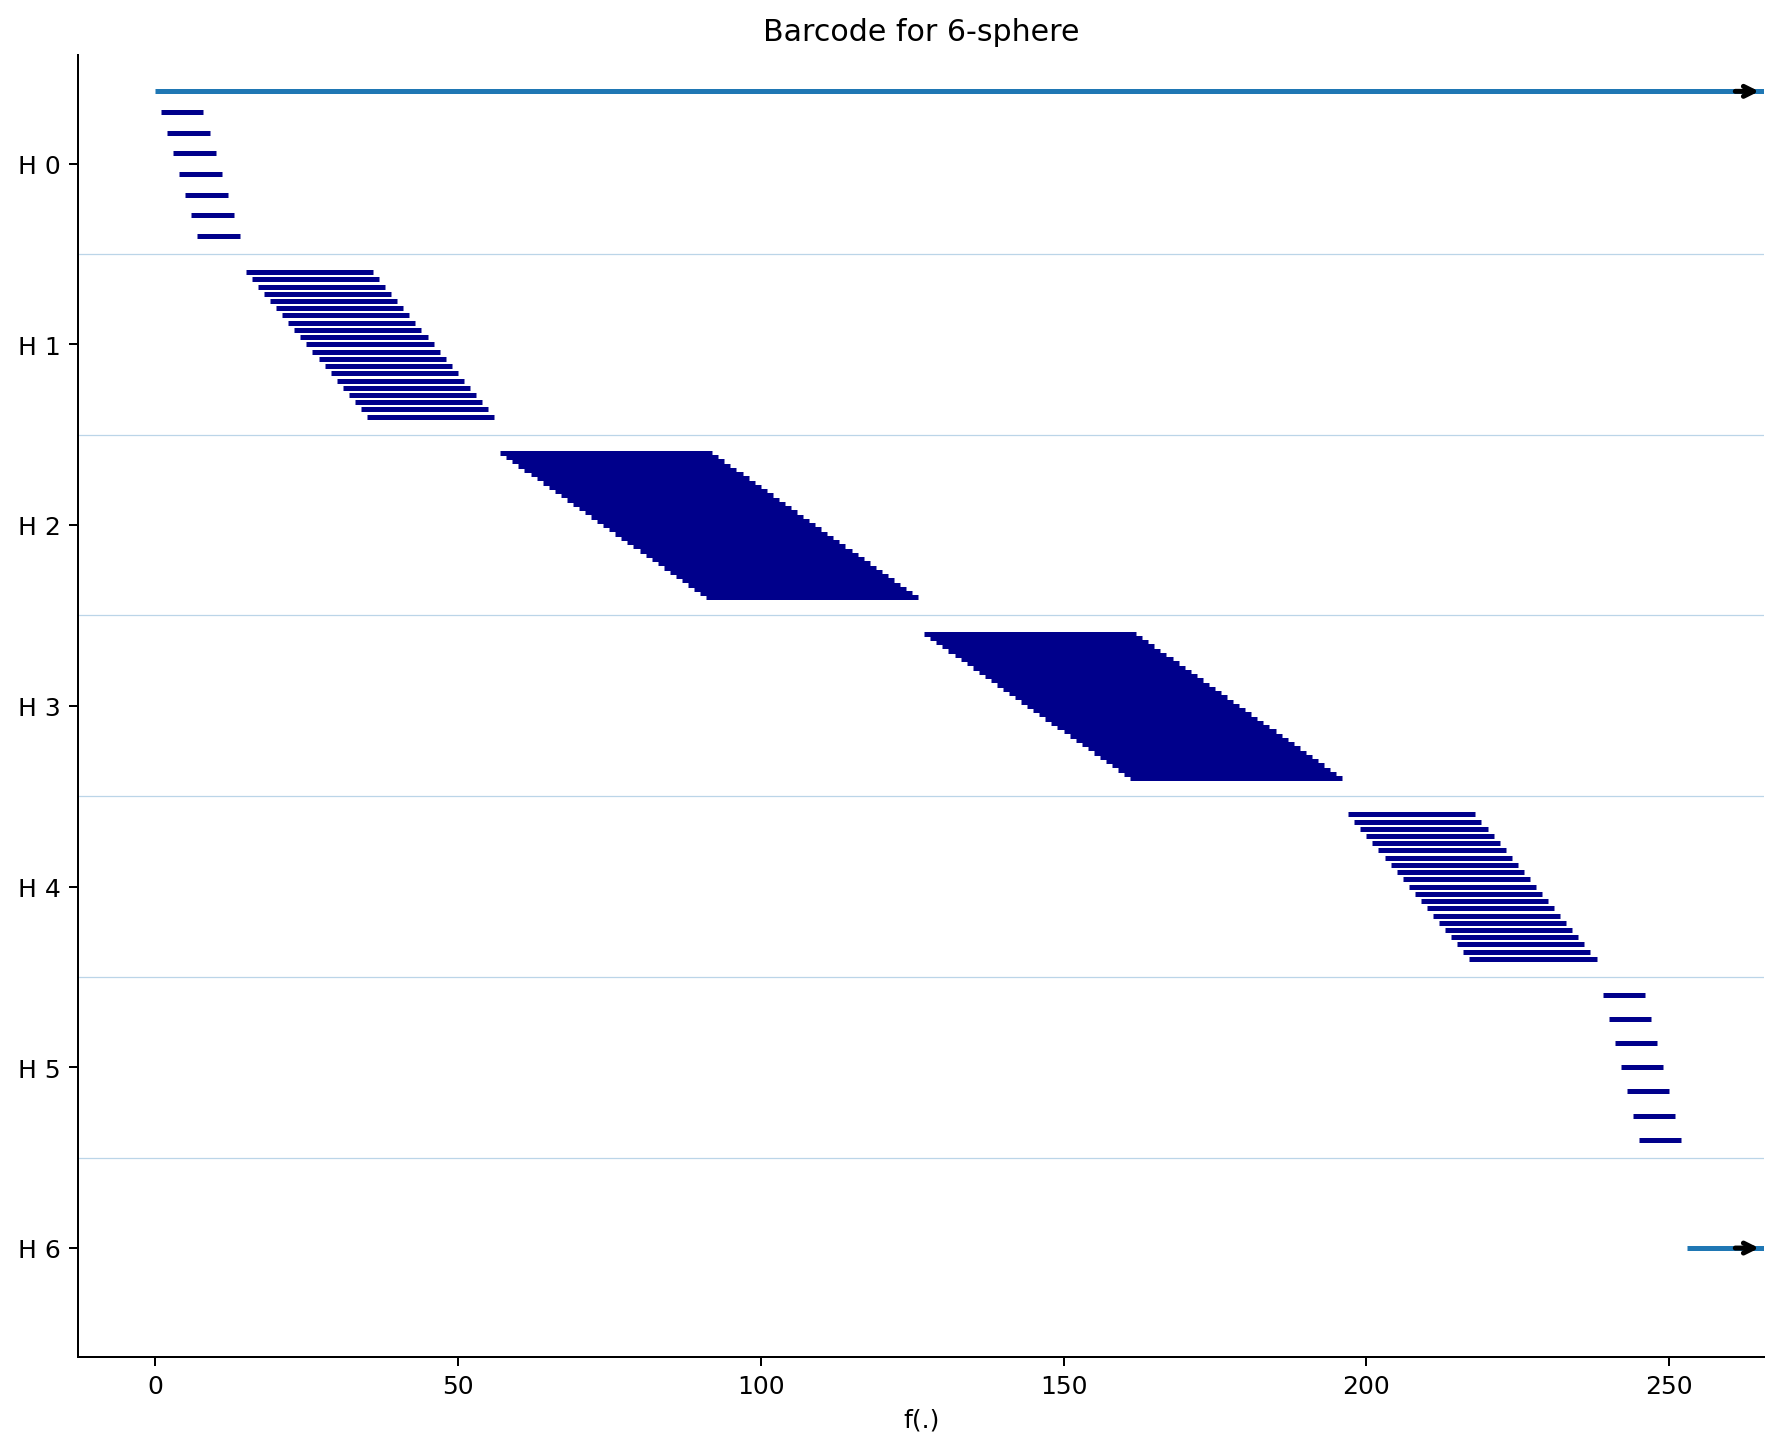

=== Computing barcode for filtration '7-sphere' ===
[smart ] time = 2.188 ms, adds = 1016, pivots = 254
Filtration time: 0.002083 s
Boundary matrix construction time: 0.002421 s
Reduction time: 0.0021876669488847256 s
Total time: 0.006691666948884726 s
Computation for 7-sphere took 0.007484
Betti: {0: 1, 7: 1}
Guess: contractible


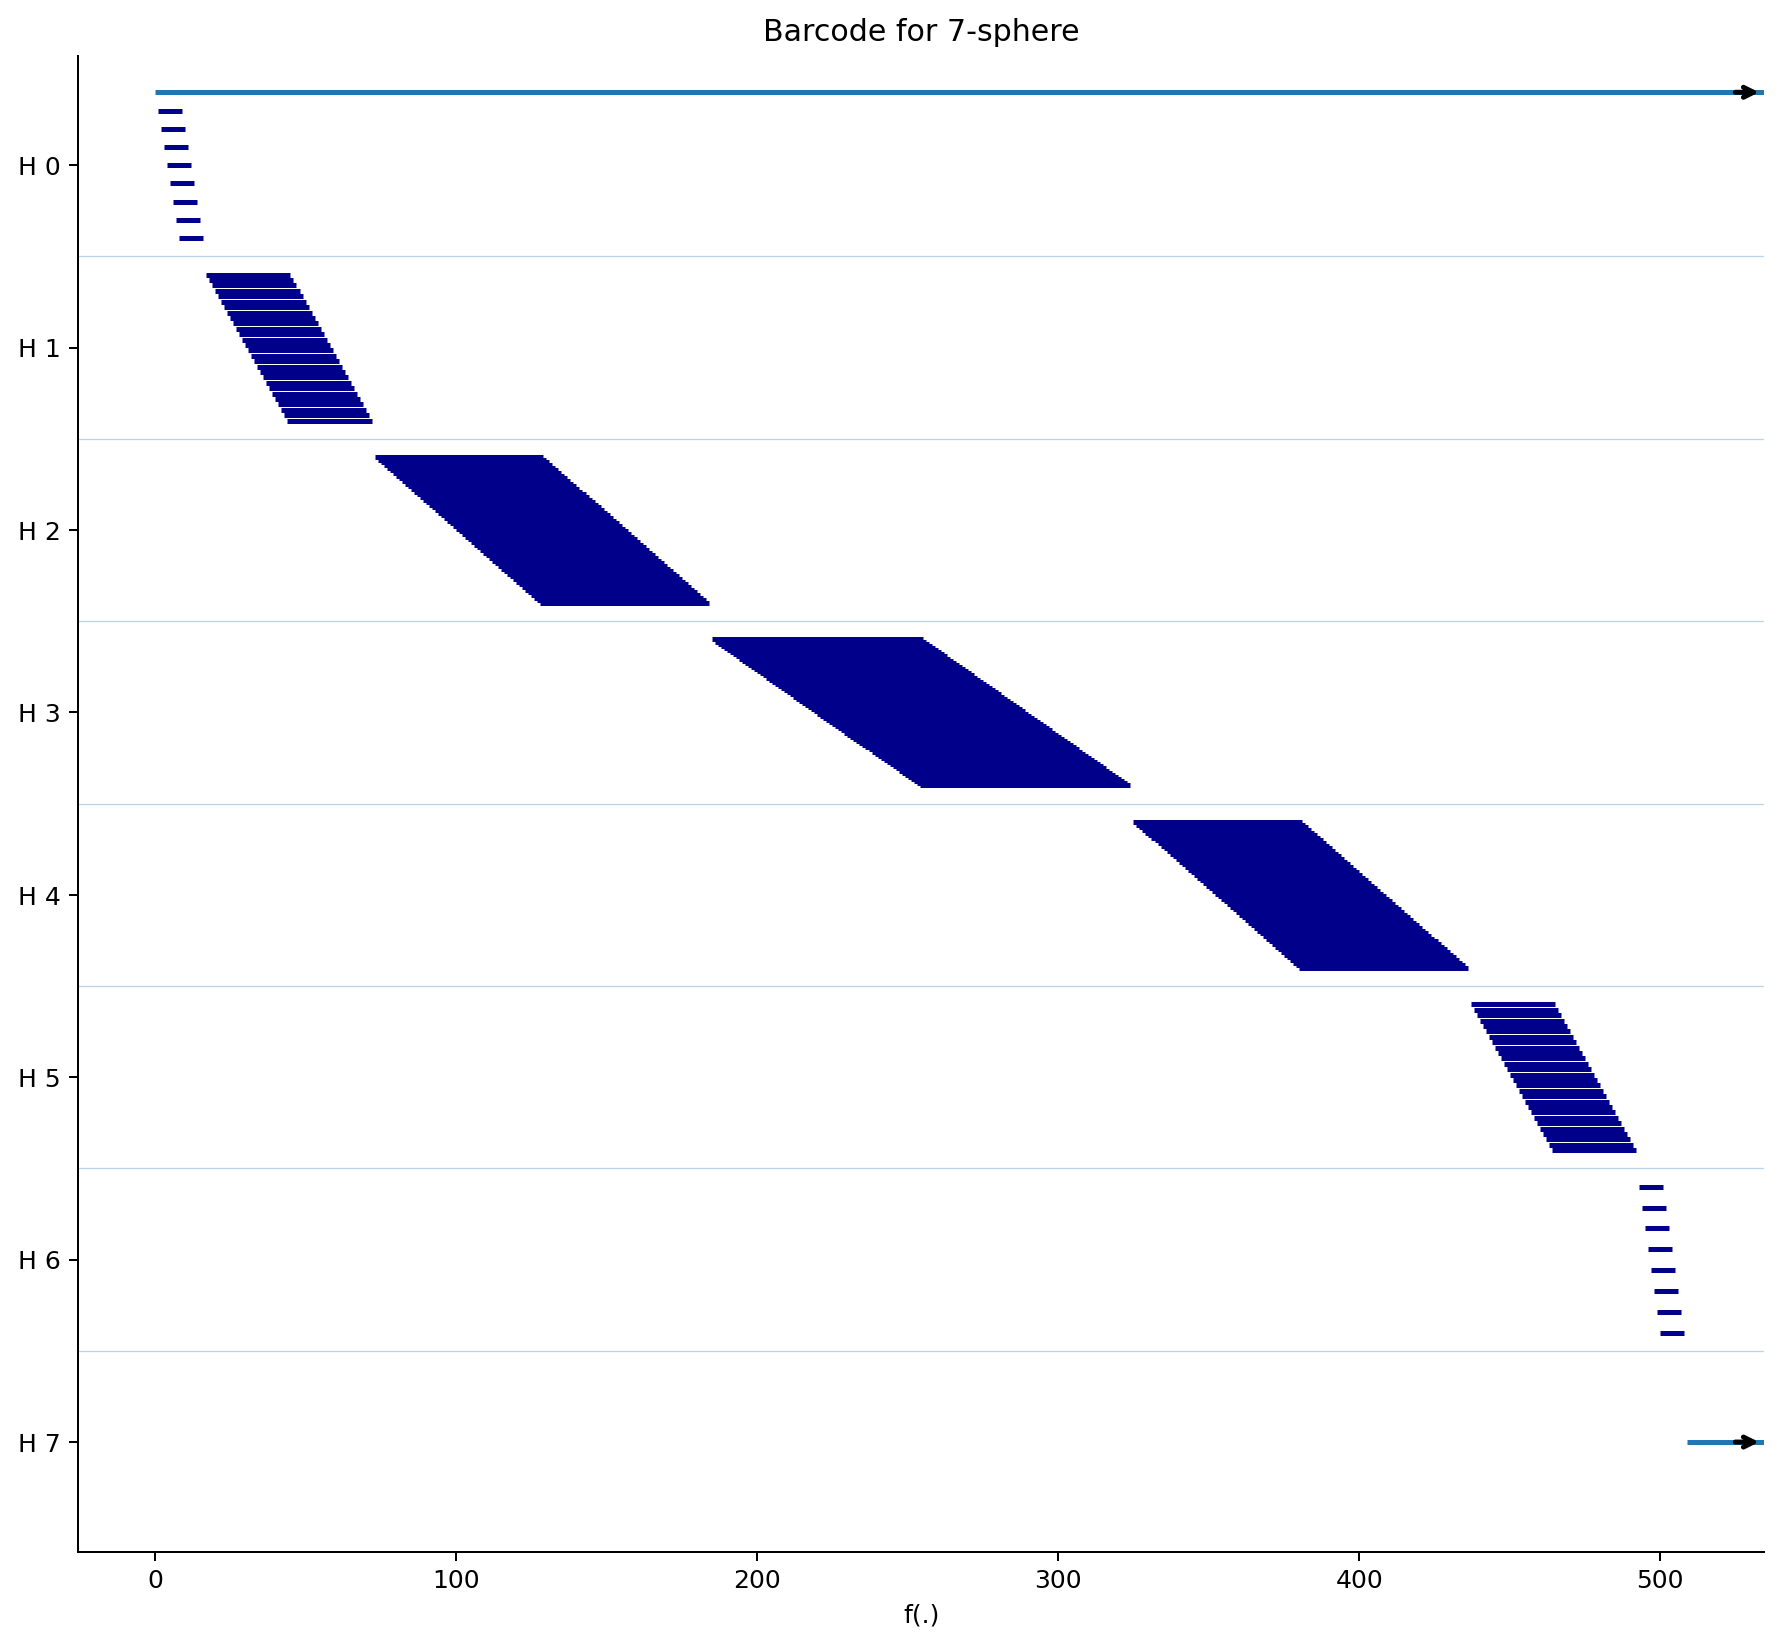

=== Computing barcode for filtration '8-sphere' ===
[smart ] time = 5.572 ms, adds = 2295, pivots = 510
Filtration time: 0.004363 s
Boundary matrix construction time: 0.003176 s
Reduction time: 0.005572082940489054 s
Total time: 0.013111082940489054 s
Computation for 8-sphere took 0.015031
Betti: {0: 1, 8: 1}
Guess: contractible


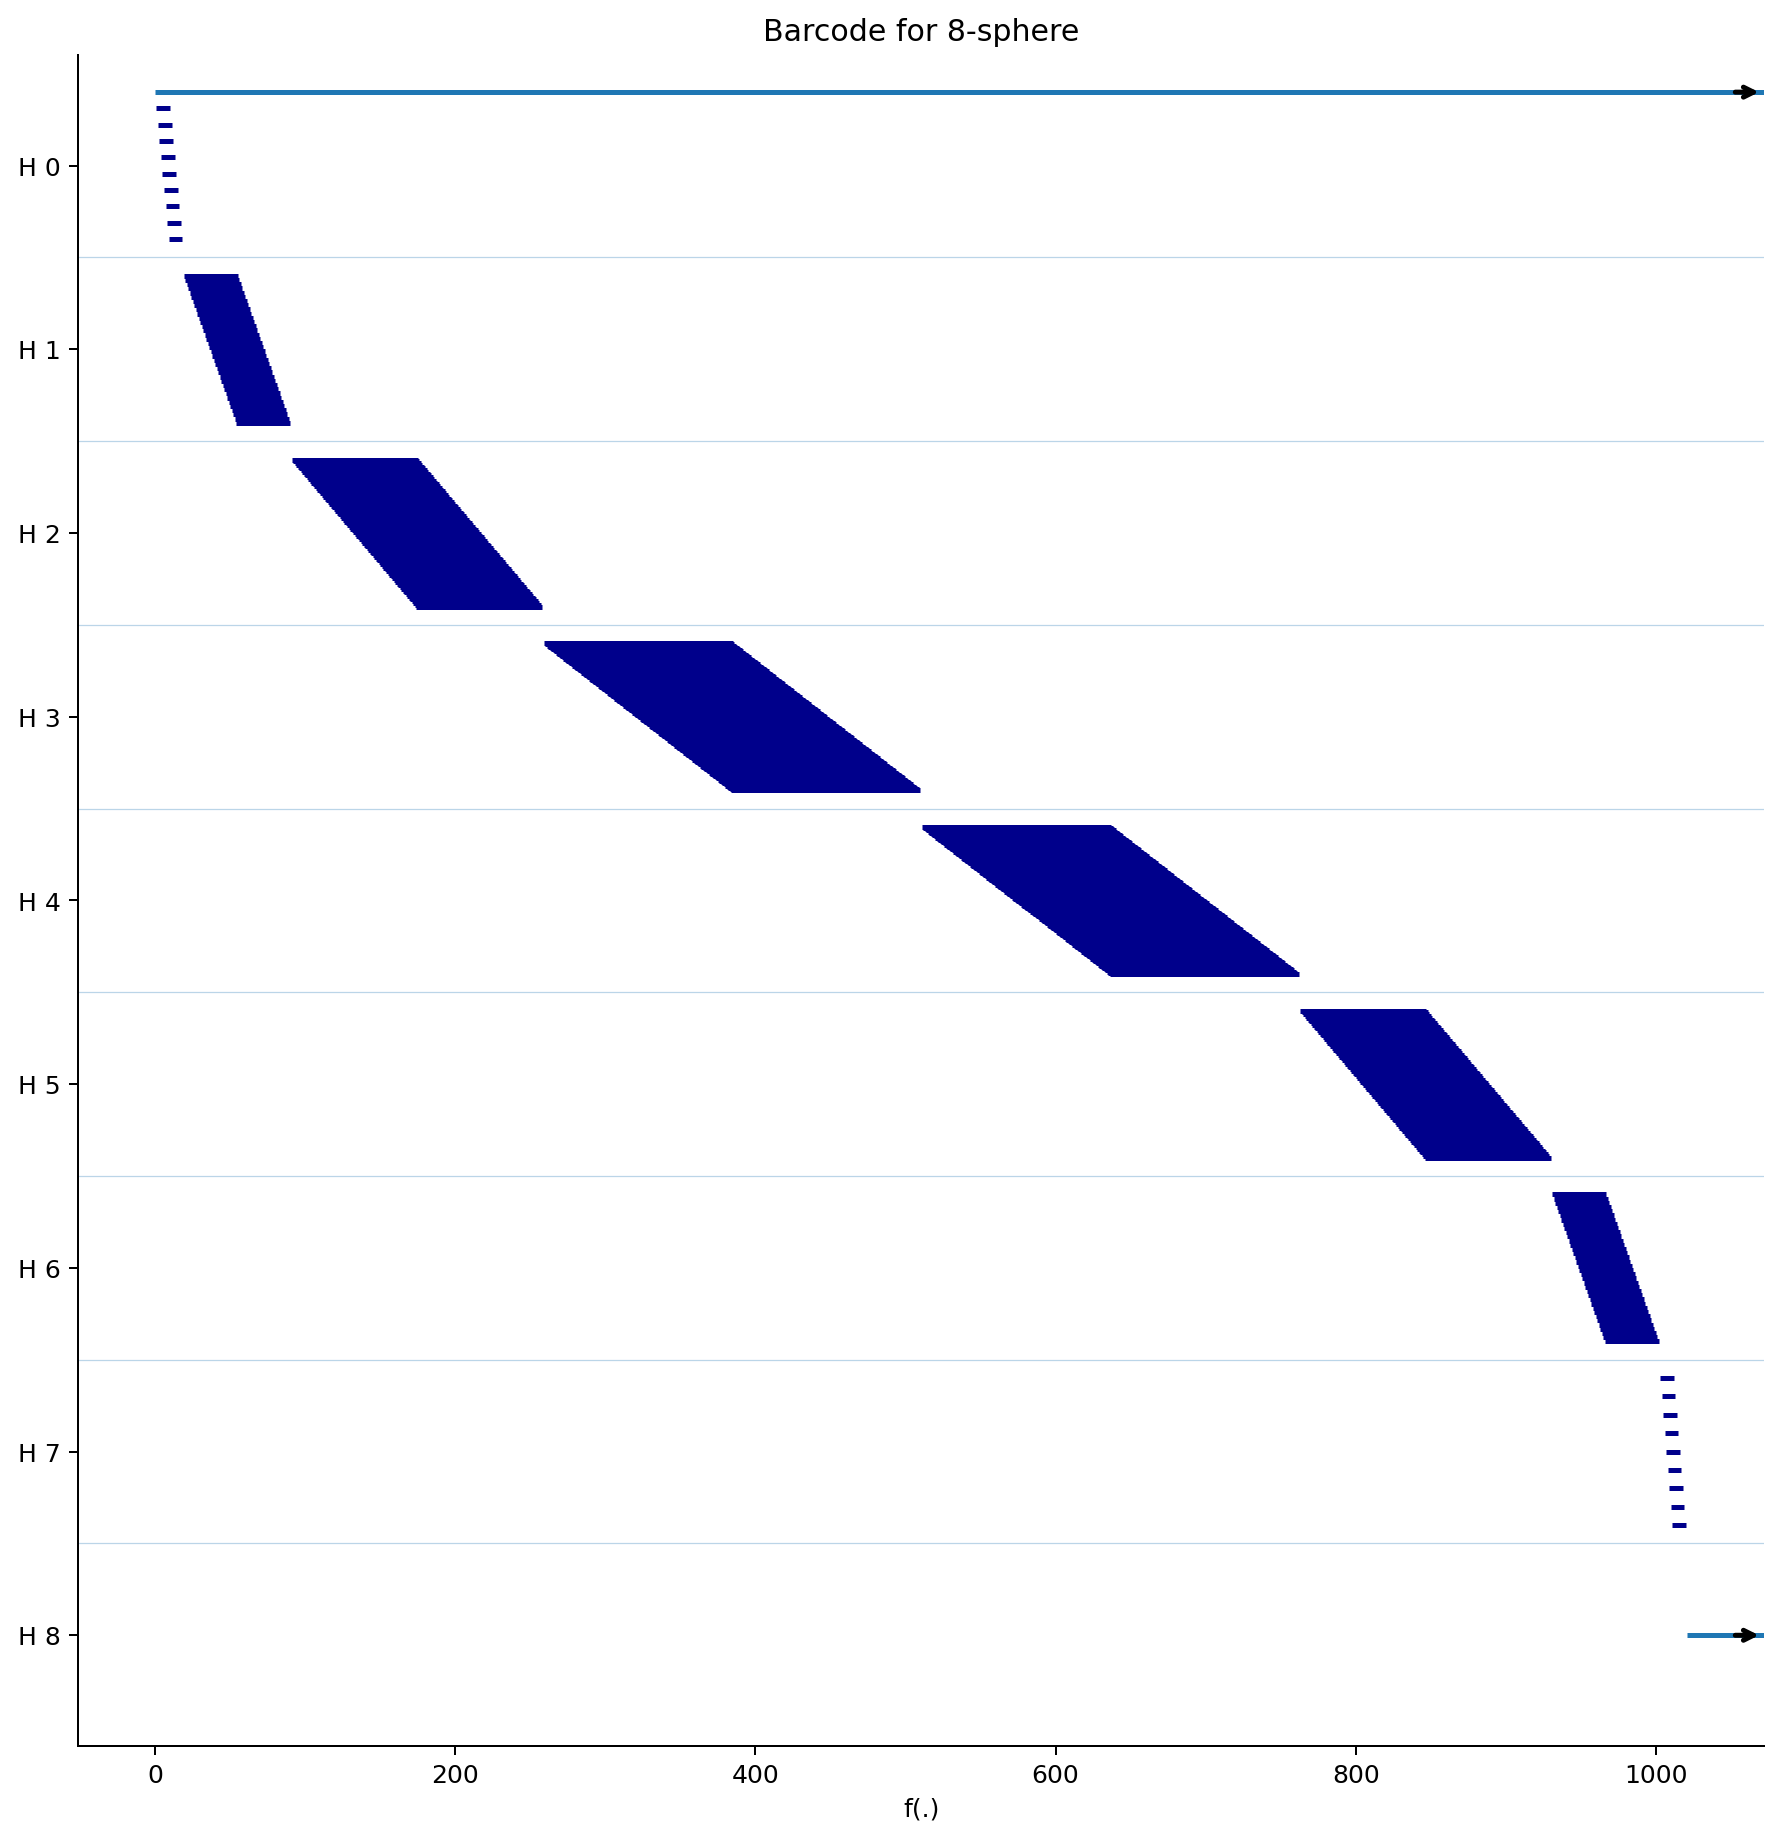

=== Computing barcode for filtration '9-sphere' ===
[smart ] time = 14.944 ms, adds = 5110, pivots = 1022
Filtration time: 0.004365 s
Boundary matrix construction time: 0.007537 s
Reduction time: 0.014944124966859818 s
Total time: 0.026846124966859817 s
Computation for 9-sphere took 0.031119
Betti: {0: 1, 9: 1}
Guess: contractible


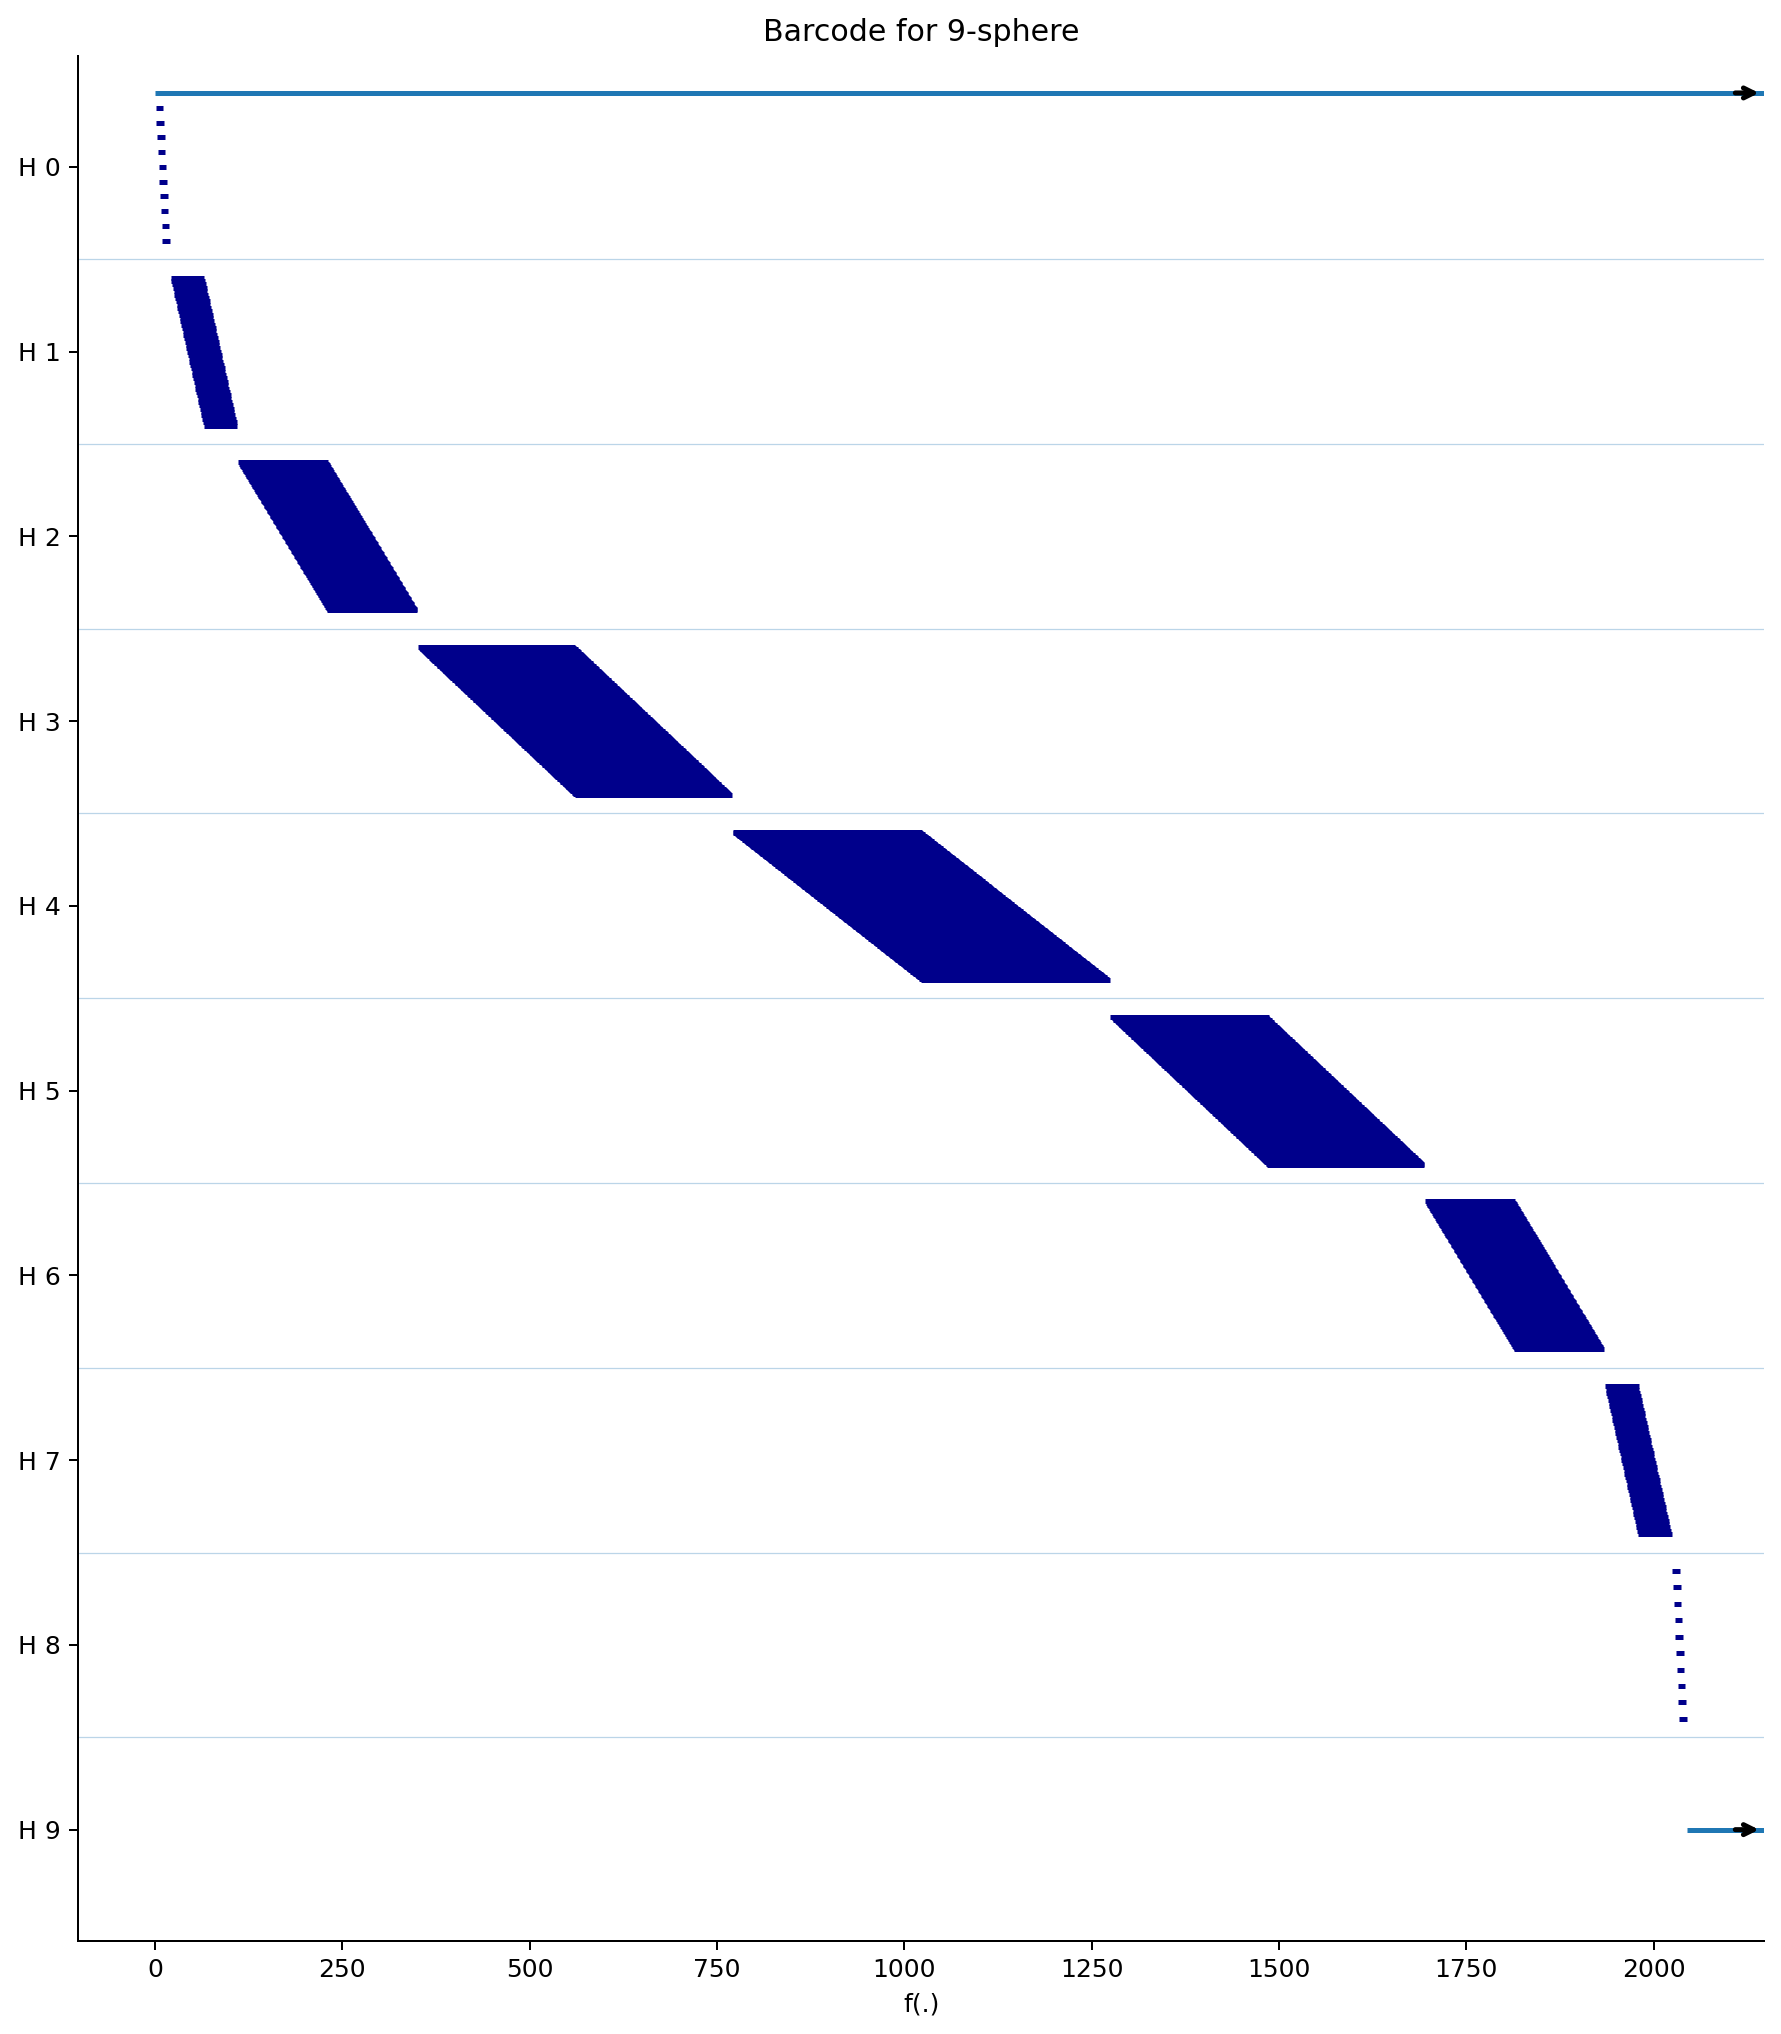

In [ ]:
# raise Exception()
for idx in range(0, 10):
    start = datetime.datetime.now()
    filename, boundary, result = get_barcode(
        filtration_path=f"../data/filtration/n-balls/{idx}-ball.txt",
        # filtration_path="../data/filtration/filtration_A.txt",
        barcode_folder_path="../data/barcodes/n-balls",
        method="smart"
    )

    print(f"Computation for {idx}-ball took {(datetime.datetime.now() - start).total_seconds()}")

    intervals = build_intervals(boundary.simplices, result.lowest_row_of_col, result.birth_to_death)
    betti = betti_from_intervals(intervals)
    print("Betti:", betti)
    print("Guess:", guess_space(betti))

    plot_barcode_reduction(
        boundary.simplices, 
        result.lowest_row_of_col,
        result.birth_to_death,
        outfile=f"../data/barcodes/n-balls/{filename}_barcode.png", 
        title="Barcode for " + filename,
    )